In [1]:
import numpy as np
import pandas as pd
import h5py
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

### Functions

In [2]:
def load_counts(counts_iter,
                binsize, 
                chromsizes, 
                depth_thrs=0,
                chroms=[str(i) for i in list(range(1,23)) + ["X"]], 
                dtype=np.int16, 
                full_len_chroms=True,
                disable_tqdm=False):
    
    """
    Load counts from chromatin data. 
    
    Parameters
    ----------
    counts_iter : iterable of hdf5 files
                  the hdf5 files should contain binned data.
    binsize : int
              size of bins used to bin the data
    chromsizes : tsv
                 tab-separated sizes of chromosomes. Seqnames must match chroms.
    depth_thrs : int
                 mininumum amount of unique molecules to include sample.
    chroms : iterable
             iterable of chromosomes to be included in analysis.
    dtype : dtype 
            Option to memory efficienct data types. https://www.tutorialspoint.com/numpy/numpy_data_types.htm
    full_len_chroms : bool
                      If True full length chromosomes will be returned.
    disable_tqdm : bool
                   if True, no tqdm progress bar will be shown. 
    
    Returns
    -------
    out : tuple, (dict(counts), dict(depths))
    
    """

    def load_chromsizes(chromsizes, binsize=binsize, chroms=chroms):
        chromsizes = pd.read_csv(chromsizes, sep='\t', header=None)
        idx = np.isin(chromsizes[0], chroms)
        if np.sum(idx) > 0:
            chromsizes = dict(zip(chromsizes[idx][0], (chromsizes[idx][1] // binsize) + 1))
        else:
            raise ValueError('No chromsizes seqnames in chroms!')

        return chromsizes

    chromsizes = load_chromsizes(chromsizes=chromsizes)

    counts_dict, depths = dict(), dict()
    for counts in tqdm(counts_iter, disable=disable_tqdm):
        try:
            bc = counts.split('/')[-1].split('.')
            rpi = int(bc[1][-2:])
            barcode = int(bc[2][-3:])
            bc = bc[0] + '.' + bc[1] + '.' + bc[2][-3:]
        except (IndexError, ValueError) as e:
            bc = bc[0]
        with h5py.File(counts, "r") as hdf5:
            if hdf5[list(hdf5)[0]].ndim > 1:
                counts = {c: np.sum(hdf5[c][:], axis=1, dtype=dtype) 
                          if c in hdf5 else np.zeros(chromsizes[c]) for c in chroms}
            else:
                counts = {c: hdf5[c][:].astype(dtype) if c in hdf5 else np.zeros(chromsizes[c]) for c in chroms}
            if full_len_chroms:
                counts = {c: np.concatenate((counts[c], np.zeros(abs(counts[c].size - chromsizes[c]), dtype=dtype))) for c in chroms} #make sure all chroms have complete length, which is not true for files generated by ../bin_countfile.py
            depth = np.sum(np.hstack(list(counts.values())))
            depths[bc] = depth
            if depth >= depth_thrs:
                counts_dict[bc] = counts
                
    return counts_dict, depths

In [3]:
def add_asisi_cluster_ticks(ax, plotchrom, xmin, xmax, tickheight=5.):
    # TODO: implement https://stackoverflow.com/a/46196281 ?
    from matplotlib.transforms import blended_transform_factory
    from matplotlib.lines import Line2D
    from matplotlib.patches import Rectangle
    clip_path = Rectangle([0, -0.2], 1, 1.2, transform=ax.transAxes)
    
    transform = blended_transform_factory(ax.transData, ax.transAxes)
    L = tickheight / ax.transAxes.get_matrix()[1, 1]
    # note that things like `linewidth` are not relatable to `L`
    # see the above SO post for possible fix
    
    for _, regionrow in asisi_site_clusters[asisi_site_clusters["chrom"] == plotchrom].iterrows():
        a = regionrow['cluster_start'] #/ 1e6
        b = regionrow['cluster_end'] #/ 1e6
        if regionrow['has_top_site']:
            color = 'red'
        else:
            color = 'black'
        r = Rectangle(
            [a, 0],
            b - a,
            -1 * L,
            color=color, lw=1.,
            antialiased=False,
            clip_on=True,
            clip_path=clip_path,
            transform=transform,
        )
        # https://matplotlib.org/stable/gallery/images_contours_and_fields/image_clip_path.html
        ax.add_patch(r)
        r.set_clip_path(clip_path)
        
    # add individual sites:
    for _, regionrow in asisi_sites[asisi_sites["chrom"] == plotchrom].iterrows():
        color = ('red' if regionrow['is_top_site'] else 'black')
        c = (regionrow["start"] + regionrow["end"]) // 2
        cbinned = c / 1e6
        l = Line2D([cbinned, cbinned], [-3 * L, -2 * L], color=color, lw=1., clip_on=True, clip_path=clip_path, transform=transform)
        ax.add_line(l)
        l.set_clip_path(clip_path)
    ax.set_xlim(xmin, xmax)
        
    return ax

### Global variables

In [4]:
CHROMS = [str(i) for i in list(range(1,23)) + ["X"]]
CHROMSIZES = '/data/zfs/deepseq/projects/PR/metadata/hg19_chrom_sizes.tsv'
chromsizes = pd.read_csv(CHROMSIZES, sep='\t', header=None).groupby(0)[1].apply(int).to_dict()

DAMID_CUTOFF = 500
BINSIZE = 1000

EXPECTED = '/data/zfs/deepseq/projects/PR/metadata/hg19_mappability_binsize_{}.hdf5'.format(BINSIZE)
FNFMT = "/data/zfs/deepseq/projects/scRepair/experiments/%s/data/counts/%s.index%02d.DamID2_BC_%03d.top_n_4.event_counts.binsize_%d.hdf5"

### Path

In [23]:
%cd /data/zfs/deepseq/projects/scRepair/

/data/zfs/deepseq/projects/scRepair


### Pre-run

In [24]:
%run -i ./notebooks/preface/load_posarray_and_mappability.ipynb

/tmp/ipykernel_120505/2307302672.py:3: UserWarning: Use the refactored 'screpairutils' module instead
  warnings.warn("Use the refactored 'screpairutils' module instead")


Skipping MT


/tmp/ipykernel_120505/2052425525.py:1: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for chrom, chromsubdf in blacklisttbl.groupby(["chrom"]):


In [25]:
%run -i ./notebooks/preface/screpair_utils.ipynb

/tmp/ipykernel_120505/2307302672.py:3: UserWarning: Use the refactored 'screpairutils' module instead
  warnings.warn("Use the refactored 'screpairutils' module instead")


### Plotting

In [26]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib.transforms import blended_transform_factory
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import seaborn
import colorcet as cc
import scipy

In [30]:
%run -i ./notebooks/preface/publishing_grade_figures.ipynb

In [28]:
plt.matplotlib.rcParams['figure.dpi'] = 90

In [29]:
SMOOTH_STDDEV_PLOT = 250e3

W_plot = scipy.signal.windows.gaussian(int(np.ceil(3 * SMOOTH_STDDEV_PLOT / BINSIZE)) * 2 + 1, SMOOTH_STDDEV_PLOT / BINSIZE)
W_plot /= W_plot.sum()

In [11]:
def add_asisi_site_ticks(ax, plotchrom):
    # TODO: implement https://stackoverflow.com/a/46196281 ?
    transform = blended_transform_factory(ax.transData, ax.transAxes)
    for isite, (sitedf, color) in enumerate(zip([top_sites, asisi_sites], ['red', 'black'])):
        for _, regionrow in sitedf[sitedf["chrom"] == plotchrom].iterrows():
            c = (regionrow["start"] + regionrow["end"]) // 2
            cbinned = c #/ 1e6
            l = Line2D([cbinned, cbinned], [0 + isite * 0.05, 0 + (isite + 1) * 0.05], color=color, lw=1.25, clip_on=True, transform=transform)
            ax.add_line(l)
    return ax

### Parse data

_Metadata_

In [15]:
anno = pd.read_csv('/data/zfs/deepseq/projects/scRepair/experiments/KIN9429/metadata/KIN9429_anno.tsv', sep='\t', index_col=0)

anno.head()

,limsid,experiment,platenr,indexnr,barcodenr,_column,_row,_well,ab_conc,antibody,...,clone_batch,clone_id,date_sorted,library_type,plate_id,sort_instrument,tamox_ind,tubenr,dam_counts,chic_counts
KIN9429.index05.001,KIN9429,ChIC18,1,5,1,1,A,A1,[1/200],CTCF,...,R66-2019-20,R66,20230824,Dam&ChIC,C1801,CytoFLEX,yes,1,101,182
KIN9429.index05.002,KIN9429,ChIC18,1,5,2,2,A,A2,[1/200],CTCF,...,R66-2019-20,R66,20230824,Dam&ChIC,C1801,CytoFLEX,yes,1,18865,4951
KIN9429.index05.003,KIN9429,ChIC18,1,5,3,3,A,A3,[1/200],CTCF,...,R66-2019-20,R66,20230824,Dam&ChIC,C1801,CytoFLEX,yes,1,234,71
KIN9429.index05.004,KIN9429,ChIC18,1,5,4,4,A,A4,[1/200],CTCF,...,R66-2019-20,R66,20230824,Dam&ChIC,C1801,CytoFLEX,yes,1,7508,2605
KIN9429.index05.005,KIN9429,ChIC18,1,5,5,5,A,A5,[1/200],CTCF,...,R66-2019-20,R66,20230824,Dam&ChIC,C1801,CytoFLEX,yes,1,59,18


In [16]:
anno.shape

(3072, 23)

_DamID_

In [17]:
hdf5_list = [FNFMT %(l,l,i,b,BINSIZE) for l,i,b in anno.loc[(anno['tamox_ind'] == 'yes') & 
                                                            (anno['clone_id'] == 'R66') & 
                                                            (anno['antibody'] == 'SMC1') & 
                                                            (anno['cellcount'] == 1) & 
                                                            (anno['dam_counts'] >= DAMID_CUTOFF),
                                                            ['limsid','indexnr','barcodenr']].values
]
len(hdf5_list)

308

In [18]:
counts_dam, depths = load_counts(hdf5_list, 
                                 BINSIZE, 
                                 CHROMSIZES, 
                                 depth_thrs=500, 
                                 dtype=np.int8, 
                                 full_len_chroms=False
)
len(counts_dam)

  0%|          | 0/308 [00:00<?, ?it/s]

308

### Analyses

### MSR

_background_

In [19]:
hdf5_list = [FNFMT %(l,l,i,b,BINSIZE) for l,i,b in anno.loc[(anno['tamox_ind'] == 'no') & 
                                                            (anno['clone_id'] == 'R66') & 
                                                            (anno['antibody'] == 'SMC1') & 
                                                            (anno['cellcount'] == 1),
                                                            ['limsid','indexnr','barcodenr']].values
]

_counts_dam, depths = load_counts(hdf5_list, 
                                  BINSIZE, 
                                  CHROMSIZES, 
                                  depth_thrs=500, 
                                  dtype=np.int8, 
                                  full_len_chroms=False
)

  0%|          | 0/60 [00:00<?, ?it/s]

In [31]:
bg = {c: np.sum([_counts_dam[bc][c] for bc in _counts_dam], axis=0) for c in CHROMS}

In [32]:
total_bg = sum(bg[c].sum() for c in CHROMS)

total_bg

579858

In [33]:
bg_sf = calc_sf(bg, w_mapab, w_mapab, alpha=2/3 - 0.05)

(total_bg - bg_sf) / total_bg

0.18482076491791635

### Plot

In [34]:
plotchrom = '22'

startpos, endpos = 10e6, 50e6

plotchrom = '1'

startpos, endpos = 0, 120.1e6

(0.0, 120.1)

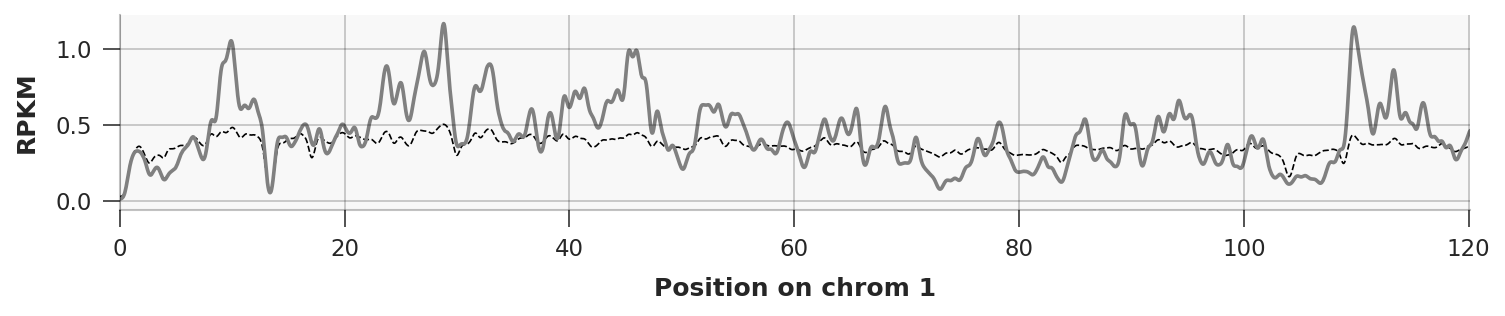

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(12, 2))

xaxis = np.arange(binned_chromsizes[plotchrom]) * (BINSIZE / 1e6)

ax.plot(
    xaxis,
    scipy.ndimage.convolve(bg[plotchrom].astype(float) / (total_bg / 1e6) / (BINSIZE / 1e3), W_plot, mode='reflect'),
    zorder=1,
    color="grey",
)

ax.plot(
    xaxis,
    scipy.ndimage.convolve(binned_mapab[plotchrom] / (total_mapab / 1e6) / (BINSIZE / 1e3), W_plot, mode='reflect'),
    zorder=0,
    color="black", linestyle="--", lw=0.8,
)

ax.set_ylabel("RPKM")
ax.set_xlabel("Position on chrom %s" % plotchrom)

add_asisi_site_ticks(ax, plotchrom)
ax.xaxis.set_major_locator(plt.matplotlib.ticker.MultipleLocator(20))
ax.set_xlim(startpos / 1e6, endpos / 1e6)

#ax.set_ylim(-.1,10.5)

### Foreground

In [62]:
bc = list(counts_dam)[30]

bc, anno.loc[bc,'dam_counts']

('KIN9429.index21.104', 555)

In [63]:
fg = counts_dam[bc]

In [64]:
sf = calc_sf(
    fg, bg, 
    w_mapab,
    alpha=2/3 - 0.05,
)

sf

486.3781620310975

Generate a plot along a chromosome:

In [65]:
_W_plot = normalized_gaussian_window(1e2 / BINSIZE)

(0.0, 120100000.0)

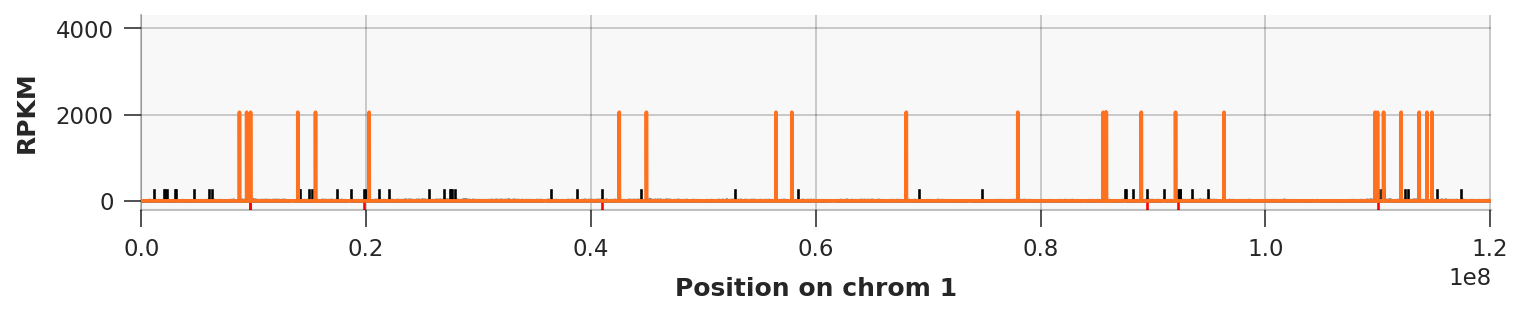

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(12, 2))

# signal from the sample
ax.plot(
    np.arange(binned_chromsizes[plotchrom]) * BINSIZE ,
    scipy.ndimage.convolve(fg[plotchrom] / (sf / 1e6) / (BINSIZE / 1e3), _W_plot, mode='reflect'),
    zorder=10,
)

# ensemble background
ax.plot(
    np.arange(binned_chromsizes[plotchrom]) * BINSIZE ,
    scipy.ndimage.convolve(bg[plotchrom].astype(float) / (total_bg / 1e6) / (BINSIZE / 1e3), _W_plot, mode='reflect'),
    zorder=2,
    color="grey",
)

# mappability
ax.plot(
    np.arange(binned_chromsizes[plotchrom]) * BINSIZE,
    scipy.ndimage.convolve(binned_mapab[plotchrom] / (total_mapab / 1e6) / (BINSIZE / 1e3), _W_plot, mode='reflect'),
    zorder=1,
    ls="--", color="black",
)

ax.set_ylabel("RPKM")
ax.set_xlabel("Position on chrom %s" % plotchrom)

# add AsiSI sites to bottom of plot:
add_asisi_site_ticks(ax, plotchrom)
ax.set_xlim(startpos , endpos )

### MSR on example sample

In [67]:
from msr.msr import MSR, get_scale_space, level2stddev
from screpairutils.msr.segmentgraph import msr_result_to_table
from screpairutils.chromtools import sum_ds

In [68]:
%%time

# run the MSR, and perform pruning

# The MSR is run per-chromosome, but the sample parameters (depth/scaling factor, positions of mappable bins, hyperparameters) should be kept constant across chromosomes
# note: the MSR has two hyperparameters: segmentation- and enrichment p-value
# furthermore, identifying (at most) a single enrichment or depletion per chromosome position is done via pruning; this pruning has one additional hyperparameter
m = MSR(
    fg, map_dict(lambda v: v.astype(float), bg),
    sf / sum_ds(bg),
    max_stddev_bins=(10e6 // BINSIZE),
    mapab=w_mapab,
    segmentation_pvalue=0.05,
    enrichment_pvalue=1e-5,
)

segment_maps = m.get_results()

CPU times: user 8.14 s, sys: 7.28 ms, total: 8.14 s
Wall time: 8.15 s


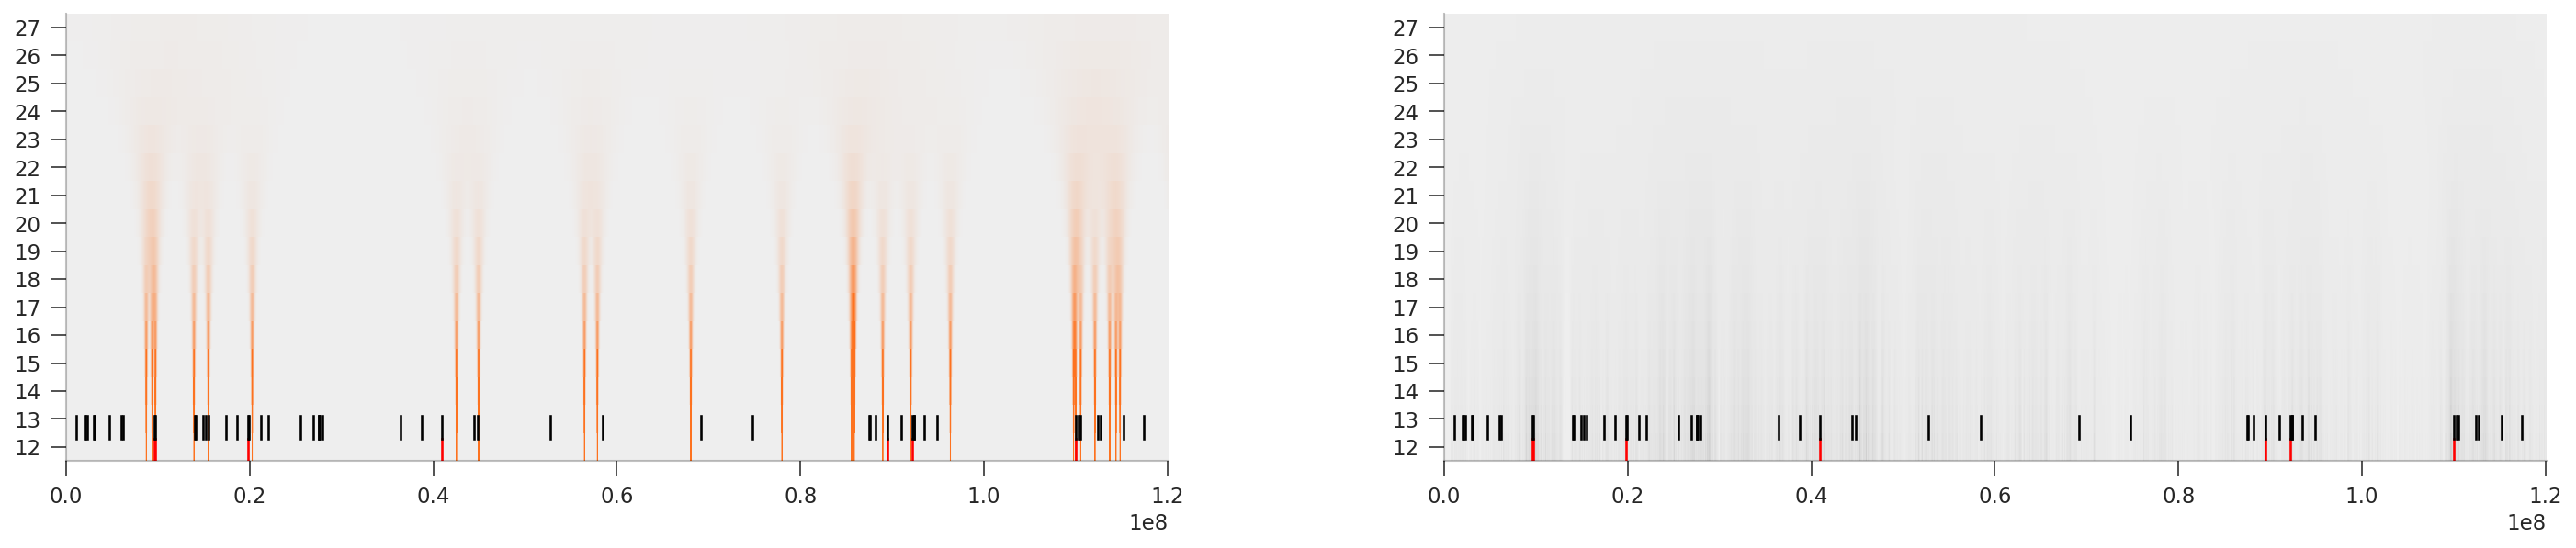

In [69]:
nlevels = 28

# scale spaces:

fig, axs = plt.subplots(1, 2, figsize=(24, 5))

ss_fg = np.array([
    get_scale_space(fg[plotchrom], level2stddev(level)) / (np.sqrt(2 * np.pi) ** (level / 2))
    for level in range(nlevels)
])

ss_bg = np.array([
    get_scale_space(bg[plotchrom], level2stddev(level)) / (np.sqrt(2 * np.pi) ** (level / 2))
    for level in range(nlevels)
])

# get fancy with colors, awaiting the executive decisions on color schemes etc
color_fg = seaborn.color_palette()[0]
color_bg = plt.matplotlib.colors.to_rgb("grey")
cmap_fg = seaborn.blend_palette(["#eee", color_fg], as_cmap=True)
cmap_bg = seaborn.blend_palette(["#eee", color_bg], as_cmap=True)

for ax, ss, n, cmap in zip(axs, (ss_fg, ss_bg), (sf, total_bg), (cmap_fg, cmap_bg)):
    ax.pcolorfast(
        np.arange(fg[plotchrom].size + 1) * BINSIZE,
        np.arange(12, nlevels + 1) - 0.5,
        ss[12:],
        vmin=0, vmax=2 * (n / 1e6) / (BINSIZE / 1e3),
        cmap=cmap,
    )
    ax.grid(False)
    ax.yaxis.set_major_locator(plt.matplotlib.ticker.MultipleLocator(1))
    ax.set_xlim(startpos, endpos)
    add_asisi_site_ticks(ax, plotchrom)

### MSR on all samples

In [34]:
outdir = '/data/zfs/deepseq/projects/scRepair/experiments/KIN9429/data/msr/'
fnfmt = '{}.msr_result_to_table.t_1_05.tsv'

In [35]:
for bc in tqdm(list(counts_dam)[197:]):
    fg = counts_dam[bc]
    sf = calc_sf(fg, 
                 bg, 
                 w_mapab,
                 alpha=2/3 - 0.05,
    )
    
    m = MSR(fg, map_dict(lambda v: v.astype(float), bg),
            sf / sum_ds(bg),
            max_stddev_bins=(10e6 // BINSIZE),
            mapab=w_mapab,
            segmentation_pvalue=0.05,
            enrichment_pvalue=1e-5,
    )

    df = msr_result_to_table(m.get_results(), T=1.05)
    df.to_csv(outdir + fnfmt.format(bc), sep='\t', index=False, header=True)

  0%|          | 0/111 [00:00<?, ?it/s]

### Results

In [36]:
msr_out = dict()
for bc in counts_dam:
    fn = outdir + fnfmt.format(bc)
    df = pd.read_csv(fn, sep='\t')
    msr_out[bc] = df[(df['enrichment'] == True) & ((df['size'] * BINSIZE) < 10e6)]

Text(0.5, 0, '# peaks per cell')

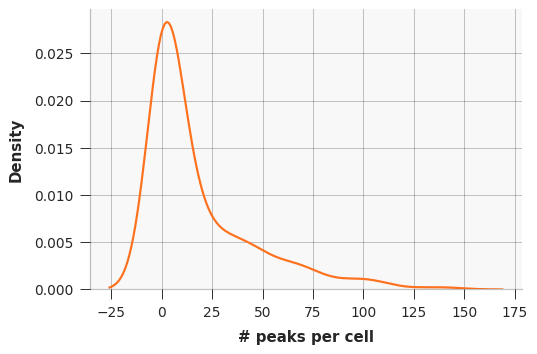

In [37]:
X = [msr_out[bc].shape[0] for bc in counts_dam]

seaborn.kdeplot(X)

plt.xlabel('# peaks per cell')

Text(0.5, 0, 'log10(peak size)')

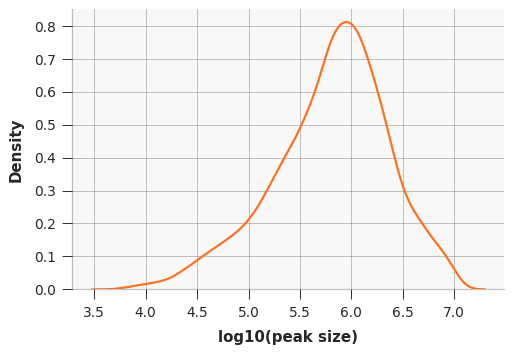

In [38]:
X = np.log10(np.hstack([msr_out[bc]['size'].values for bc in counts_dam]).astype(int) * BINSIZE)

seaborn.kdeplot(X)

plt.xlabel('log10(peak size)')